### Active learning with Gaussian process regressor (uncertainty sampling)
#### multivariate Gaussian distribution
#### n models such as Gaussian Process (GP) regression, the uncertainty in predictions is calculated based on the model's underlying probabilistic framework and does not directly use the true values of the data. Here’s how the uncertainty is typically calculated:

#### Gaussian Process regression models the relationship between inputs and outputs using a multivariate Gaussian distribution. The key idea is that any finite collection of the function values has a joint Gaussian distribution.
#### How Uncertainty is Calculated
#### Prior Distribution:
#### Before observing any data, the model assumes that the function values follow a Gaussian distribution with a mean function (often assumed to be zero) and a covariance function (kernel).
#### Kernel (Covariance Function):
#### The kernel defines the covariance between pairs of inputs. Common kernels include the Radial Basis Function (RBF) or Gaussian kernel.
#### The kernel function determines how much two points in the input space are expected to influence each other.
##### Posterior Distribution:
#### After observing data, the model updates its beliefs about the function. This is done using Bayes' theorem to obtain the posterior distribution.
#### The posterior mean and covariance are derived from the prior distribution and the observed data.

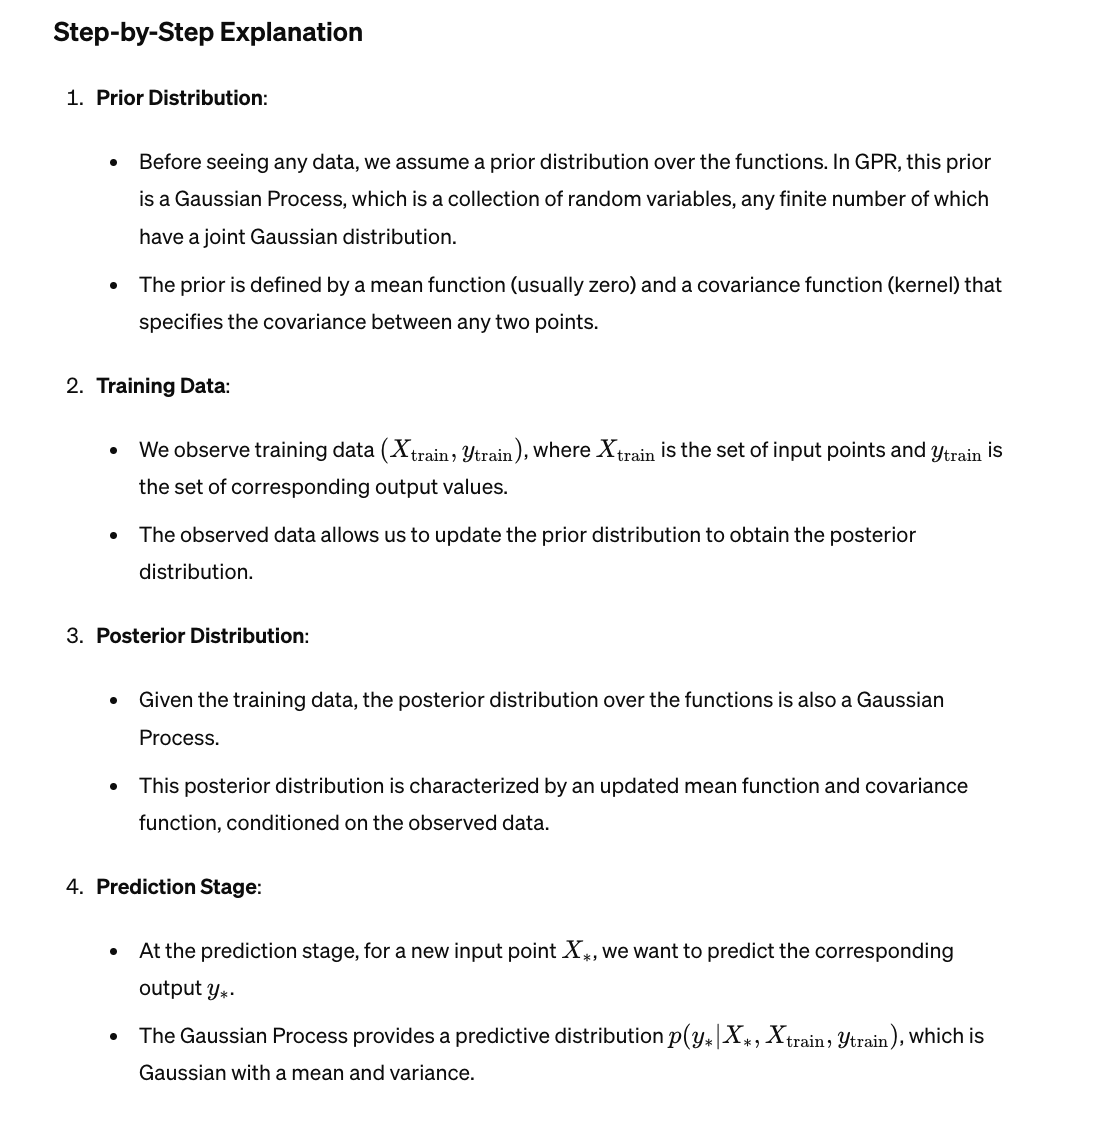


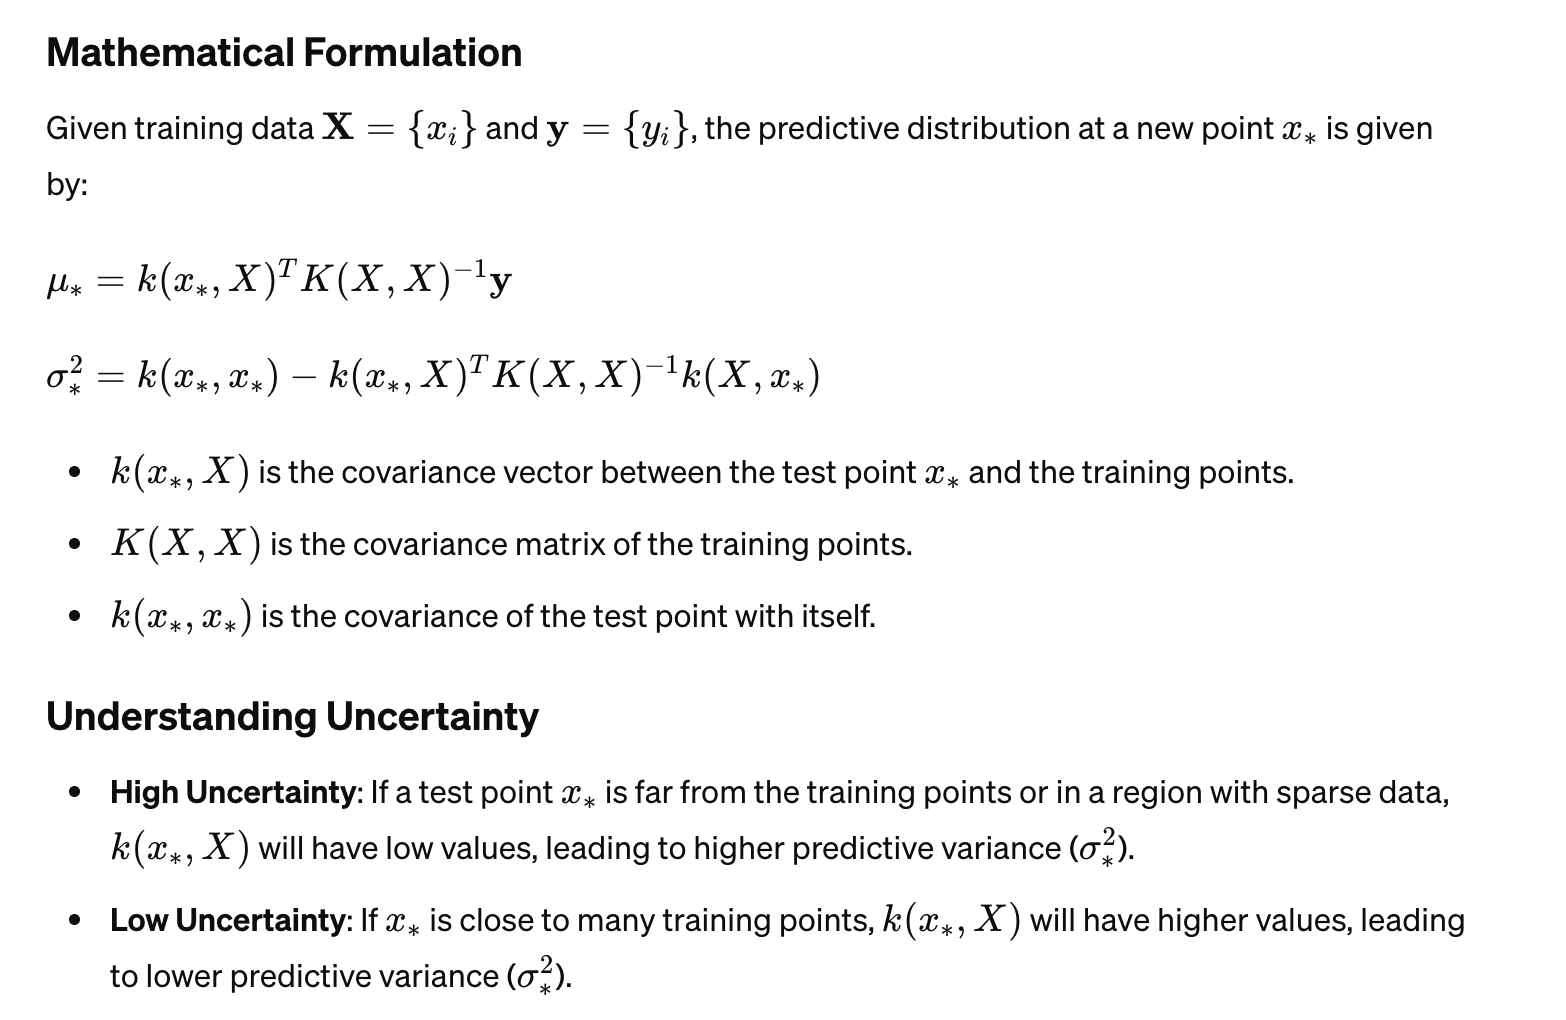

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from modAL.models import ActiveLearner

%matplotlib inline

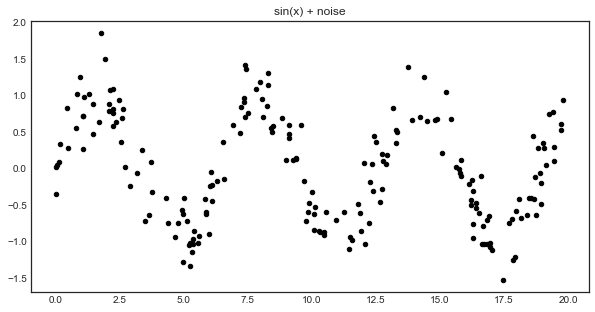

In [117]:
#synthetic data
X = np.random.choice(np.linspace(0, 20, 10000), size=200, replace=False).reshape(-1, 1)
y = np.sin(X) + np.random.normal(scale=0.3, size=X.shape)
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.scatter(X, y, c='k', s=20)
    plt.title('sin(x) + noise')
    plt.show()

In [118]:
'''
For active learning, we shall define a custom query strategy tailored to Gaussian processes. 
More information on how to write your custom query strategies can be found at the page Extending modAL. 
In a nutshell, a query stategy in modAL is a function taking (at least) two arguments 
(an estimator object and a pool of examples), outputting the index of the queried instance and the instance itself. In our case, the arguments are regressor and X.
'''


def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]

In [119]:
n_initial = 5
initial_idx = np.random.choice(range(len(X)), size=n_initial, replace=False)
X_training, y_training = X[initial_idx], y[initial_idx]

kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

regressor = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=GP_regression_std,
    X_training=X_training.reshape(-1, 1), y_training=y_training.reshape(-1, 1)
)
print(X_training)

[[18.06780678]
 [ 8.45484548]
 [ 5.22052205]
 [15.60956096]
 [16.38563856]]


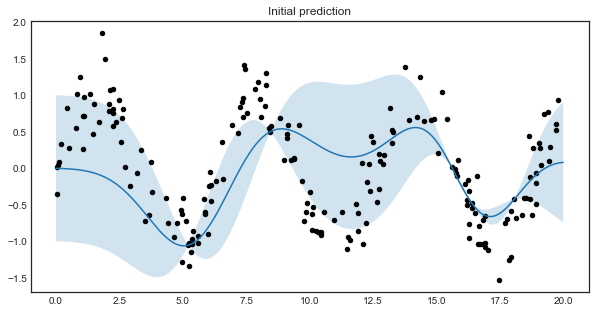

In [120]:
#initial regressor
X_grid = np.linspace(0, 20, 1000)
y_pred, y_std = regressor.predict(X_grid.reshape(-1, 1), return_std=True)
y_pred, y_std = y_pred.ravel(), y_std.ravel()

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.plot(X_grid, y_pred)
    plt.fill_between(X_grid, y_pred - y_std, y_pred + y_std, alpha=0.2)
    plt.scatter(X, y, c='k', s=20)
    plt.title('Initial prediction')
    plt.show()

Query Index: 13, Query Instance: [19.02790279]
Query Index: 0, Query Instance: [6.08660866]
Query Index: 16, Query Instance: [14.80548055]
Query Index: 56, Query Instance: [10.95509551]
Query Index: 183, Query Instance: [9.27692769]
Query Index: 128, Query Instance: [17.04570457]
Query Index: 176, Query Instance: [0.030003]
Query Index: 173, Query Instance: [0.4960496]
Query Index: 102, Query Instance: [7.84278428]
Query Index: 104, Query Instance: [4.41244124]


/Users/zhiyuwang/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/zhiyuwang/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


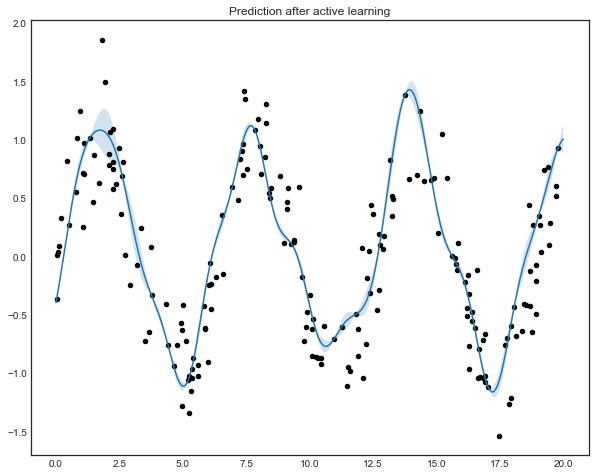

In [123]:
n_queries = 10
for idx in range(n_queries):
    query_idx, query_instance = regressor.query(X)
    #std_query_instance = np.std(query_instance,X) 
    regressor.teach(X[query_idx].reshape(1, -1), y[query_idx].reshape(1, -1))
    print(f"Query Index: {query_idx}, Query Instance: {query_instance}")

    
    
# n_queries = 10
# for idx in range(n_queries):
#     query_idx, query_instance = regressor.query(X)
#     regressor.teach(X[query_idx].reshape(1, -1), y[query_idx].reshape(1, -1))
#     # Remove the queried point from X
#     X = np.delete(X, query_idx, axis=0)
#     y = np.delete(y, query_idx, axis=0)
#     print(query_idx, query_instance)
    
    
#retrain model
y_pred_final, y_std_final = regressor.predict(X_grid.reshape(-1, 1), return_std=True)
y_pred_final, y_std_final = y_pred_final.ravel(), y_std_final.ravel()
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 8))
    plt.plot(X_grid, y_pred_final)
    plt.fill_between(X_grid, y_pred_final - y_std_final, y_pred_final + y_std_final, alpha=0.2)
    plt.scatter(X, y, c='k', s=20)
    plt.title('Prediction after active learning')
    plt.show()

### Active learning using Pytorch

In [179]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Create a synthetic regression dataset
'''
The target variable y is generated as a linear combination of the input features with some added Gaussian noise. In other words, the underlying model is approximately 
y=X⋅coef+noise, where coef is a randomly generated coefficient. The noise=0.1 parameter adds Gaussian noise to the target variable. This makes the data more realistic 
by simulating measurement errors or other sources of variability in the real world.Feature Values: The feature values in X are drawn from a standard normal distribution 
(mean=0, standard deviation=1). This means the values will generally lie within the range of -3 to 3, but can extend beyond this range.
'''
X, y = make_regression(n_samples=500, n_features=1, noise=0.1, random_state=42)
X_train, X_pool, y_train, y_pool = train_test_split(X, y, test_size=0.95, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_pool = torch.tensor(X_pool, dtype=torch.float32)
y_pool = torch.tensor(y_pool, dtype=torch.float32).view(-1, 1)
print(X_pool)

# Define a simple neural network for regression
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Function to train the model
def train(model, optimizer, criterion, X_train, y_train, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

# Function to get predictions and their variances
def predict_with_uncertainty(model, X, n_iter=10): 
    model.eval()
    preds = []
    for _ in range(n_iter):
        outputs = model(X)
        preds.append(outputs.detach().numpy())
        #print(n_iter,X,outputs)
    preds = np.array(preds)
    mean_preds = preds.mean(axis=0)
    var_preds = preds.var(axis=0)
    return mean_preds, var_preds



tensor([[ 0.5426],
        [-0.5258],
        [ 0.1833],
        [-0.8613],
        [ 0.6142],
        [ 0.7674],
        [-0.7304],
        [-1.7587],
        [-0.7833],
        [ 0.2970],
        [ 0.0977],
        [ 1.4028],
        [ 0.7140],
        [ 0.0741],
        [-0.4710],
        [-0.6772],
        [-1.2609],
        [ 0.6241],
        [ 1.3669],
        [-0.0327],
        [ 0.5138],
        [-0.8756],
        [ 0.8219],
        [-0.0555],
        [-0.0720],
        [ 2.3147],
        [-1.3828],
        [-0.8182],
        [-0.3221],
        [-0.7144],
        [-0.4657],
        [-0.3011],
        [ 0.8225],
        [-0.1279],
        [ 0.4732],
        [-1.7034],
        [ 0.3570],
        [-0.8839],
        [-0.7485],
        [ 1.2378],
        [-1.0060],
        [ 1.1632],
        [ 0.5144],
        [-1.3202],
        [-1.0128],
        [ 0.7917],
        [-0.8083],
        [ 0.0918],
        [-0.0347],
        [ 0.6339],
        [ 0.0102],
        [ 0.3241],
        [-0.

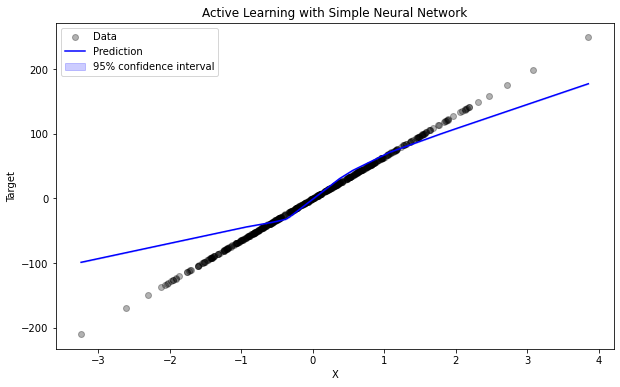

In [180]:
# Initialize the model, optimizer, and loss function
model = SimpleNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Initial training with a small labeled dataset
train(model, optimizer, criterion, X_train, y_train, epochs=100)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='black', label='Data',alpha=0.3)
X_plot = torch.linspace(X.min(), X.max(), 1000).view(-1, 1)
y_mean, y_std = predict_with_uncertainty(model, X_plot, n_iter=10)
plt.plot(X_plot.numpy(), y_mean, color='blue', label='Prediction')
plt.fill_between(X_plot.numpy().ravel(), (y_mean - 1.96*y_std).ravel(), (y_mean + 1.96*y_std).ravel(), color='blue', alpha=0.2, label='95% confidence interval')
plt.xlabel('X')
plt.ylabel('Target')
plt.title('Active Learning with Simple Neural Network')
plt.legend()
plt.show()

167 tensor([[2.1222]])
25 tensor([[2.3147]])
118 tensor([[-1.9597]])
456 tensor([[3.8527]])
68 tensor([[1.6450]])
59 tensor([[-2.1239]])
120 tensor([[-1.6127]])
90 tensor([[1.9647]])
134 tensor([[-3.2413]])
88 tensor([[-1.7131]])
Model Mean Squared Error: 0.82


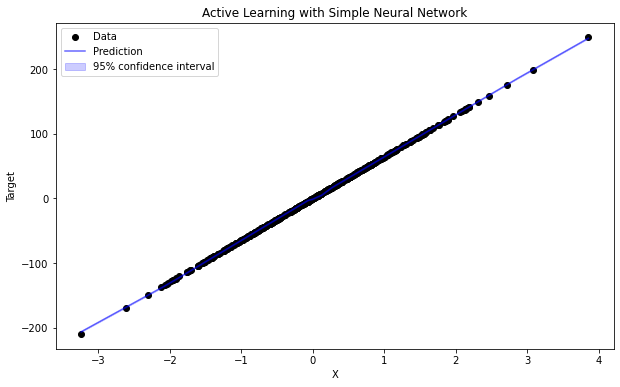

In [181]:
# Active learning loop
n_queries = 10
for _ in range(n_queries):
    # Get predictions and their variances for the pool
    _, variances = predict_with_uncertainty(model, X_pool, n_iter=10)
    
    # Select the data point with the highest variance
    query_idx = np.argmax(variances)
    X_query = X_pool[query_idx].view(1, -1)
    y_query = y_pool[query_idx].view(1, -1)
    print(query_idx, X_query)
    
    # Add the queried point to the training set
    X_train = torch.cat([X_train, X_query])
    y_train = torch.cat([y_train, y_query])
    
    # Remove the queried point from the pool
    X_pool = torch.cat([X_pool[:query_idx], X_pool[query_idx+1:]])
    y_pool = torch.cat([y_pool[:query_idx], y_pool[query_idx+1:]])
    
    # Retrain the model
    train(model, optimizer, criterion, X_train, y_train, epochs=100)

# Evaluate the model
y_pred, _ = predict_with_uncertainty(model, X_pool, n_iter=10)
mse = mean_squared_error(y_pool.numpy(), y_pred)
print(f"Model Mean Squared Error: {mse:.2f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='black', label='Data')
X_plot = torch.linspace(X.min(), X.max(), 1000).view(-1, 1)
y_mean, y_std = predict_with_uncertainty(model, X_plot, n_iter=10)
plt.plot(X_plot.numpy(), y_mean, color='blue', label='Prediction',alpha=0.6)
plt.fill_between(X_plot.numpy().ravel(), (y_mean - 1.96*y_std).ravel(), (y_mean + 1.96*y_std).ravel(), color='blue', alpha=0.2, label='95% confidence interval')
plt.xlabel('X')
plt.ylabel('Target')
plt.title('Active Learning with Simple Neural Network')
plt.legend()
plt.show()


### VAE (generate multiple Y from same x and get variance)

In [216]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

# Define VAE components
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = torch.relu(self.fc(x))
        return self.mu(h), self.logvar(h)

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc(z))
        return torch.sigmoid(self.out(h))

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

# Train VAE
def train_vae(model, dataloader, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        for batch in dataloader:
            x, _ = batch
            x = x.view(x.size(0), -1)
            optimizer.zero_grad()
            recon, mu, logvar = model(x)
            recon_loss = criterion(recon, x)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + kl_loss
            loss.backward()
            optimizer.step()

# Generate samples and estimate uncertainty
 # mean and variance for each x 
def generate_with_uncertainty(model, x, n_iter=10): 
    model.eval()
    samples = []
    with torch.no_grad():
        for _ in range( n_iter):
            recon, _, _ = model(x)
            samples.append(recon.cpu().numpy())
    samples = np.array(samples)
    mean_sample = samples.mean(axis=0)
    var_sample = samples.var(axis=0)
    print(x,mean_sample ,var_sample)
    return mean_sample, var_sample



In [217]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
mnist = datasets.MNIST('.', train=True, download=True, transform=transform)
dataloader = DataLoader(mnist, batch_size=128, shuffle=True)

vae = VAE(input_dim=784, hidden_dim=400, latent_dim=20)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
criterion = nn.BCELoss(reduction='sum')

train_vae(vae, dataloader, optimizer, criterion, epochs=10)

x, _ = mnist[0]
x = x.view(1, -1)
mean, var = generate_with_uncertainty(vae, x)  
#print("Mean:", mean)
#print("Variance:", var)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

### Monte Carlo Dropout in Bayesian Neural Network
#### method 1: not explicitly select data point for retrain but use Monte carlo dropout to evluate the loss to optimize the weight distribution

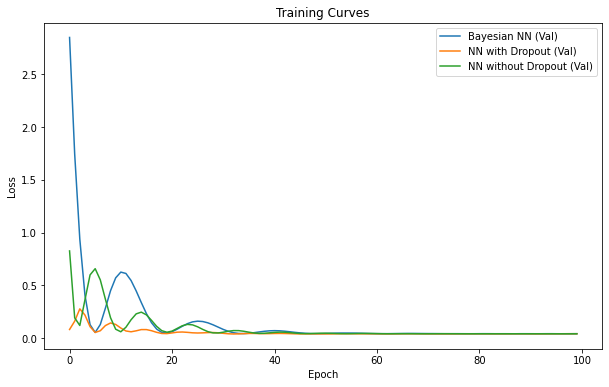

In [205]:
### import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Generate synthetic data
def generate_data(n_samples=1000):
    X = torch.randn(n_samples, 1) * 2 + 1  # Input features
    y = X * 0.5 + torch.randn(n_samples, 1) * 0.2  # Labels with noise
    return X, y

# Bayesian Neural Network with Monte Carlo Dropout
class BayesianNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=64, num_passes=10, dropout_rate=0.2):
        super(BayesianNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.num_passes = num_passes

    def forward(self, x):
        outputs = torch.zeros(x.size(0), self.num_passes, self.fc2.out_features)
        for i in range(self.num_passes):
            x_ = F.relu(self.fc1(x))  # Corrected line
            x_ = self.dropout(x_)
            outputs[:, i] = self.fc2(x_)
        return outputs.mean(dim=1), outputs.std(dim=1)

# Regular Neural Network with Dropout
class NNWithDropout(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=64, dropout_rate=0.2):
        super(NNWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Regular Neural Network without Dropout
class NNWithoutDropout(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=64):
        super(NNWithoutDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train and evaluate
def train_and_evaluate(model, X_train, y_train, X_val, y_val, epochs=100, lr=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        if isinstance(model, BayesianNN):
            outputs, _ = model(X_train)
            loss = criterion(outputs, y_train)
        else:
            outputs = model(X_train)
            loss = criterion(outputs, y_train)

        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            if isinstance(model, BayesianNN):
                outputs, _ = model(X_train)
                train_loss = criterion(outputs, y_train)
                outputs, _ = model(X_val)
                val_loss = criterion(outputs, y_val)
            else:
                outputs = model(X_train)
                train_loss = criterion(outputs, y_train)
                outputs = model(X_val)
                val_loss = criterion(outputs, y_val)

        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

    return train_losses, val_losses

# Generate synthetic data
X, y = generate_data()

# Split data into train and validation
n_samples = X.shape[0]
n_train = int(0.8 * n_samples)
X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:], y[n_train:]



# Create dataloaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=False)

# Train and evaluate models'
input_size = X_train.shape[1] 
bayesian_model = BayesianNN(input_size, 1, num_passes=10)
dropout_model = NNWithDropout(input_size, 1)
no_dropout_model = NNWithoutDropout(input_size, 1)

train_losses_bayesian, val_losses_bayesian = train_and_evaluate(bayesian_model, X_train, y_train, X_val, y_val)
train_losses_dropout, val_losses_dropout = train_and_evaluate(dropout_model, X_train, y_train, X_val, y_val)
train_losses_no_dropout, val_losses_no_dropout = train_and_evaluate(no_dropout_model, X_train, y_train, X_val, y_val)

# Plot training curves
plt.figure(figsize=(10, 6))
#plt.plot(train_losses_bayesian, label='Bayesian NN (Train)')
plt.plot(val_losses_bayesian, label='Bayesian NN (Val)')
#plt.plot(train_losses_dropout, label='NN with Dropout (Train)')
plt.plot(val_losses_dropout, label='NN with Dropout (Val)')
#plt.plot(train_losses_no_dropout, label='NN without Dropout (Train)')
plt.plot(val_losses_no_dropout, label='NN without Dropout (Val)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Curves')
plt.legend()
plt.show()

#### Method2: do explicit data selection based out multiple dropout inference iteration and retrain

tensor([], size=(0, 1)) tensor([], size=(0, 1))


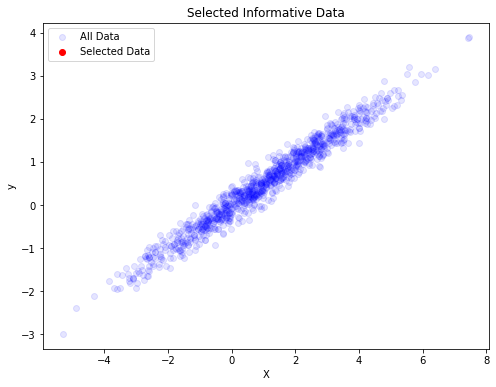

In [215]:
# Generate synthetic data
def generate_data(n_samples=1000):
    X = torch.randn(n_samples, 1) * 2 + 1  # Input features
    y = X * 0.5 + torch.randn(n_samples, 1) * 0.2  # Labels with noise
    return X, y

# Bayesian Neural Network with Monte Carlo Dropout
class BayesianNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=64, num_passes=10, dropout_rate=0.2):
        super(BayesianNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.num_passes = num_passes

    def forward(self, x):
        outputs = torch.zeros(x.size(0), self.num_passes, self.fc2.out_features)
        for i in range(self.num_passes):
            x_ = F.relu(self.fc1(x))
            x_ = self.dropout(x_)
            outputs[:, i] = self.fc2(x_)
        return outputs.mean(dim=1), outputs.std(dim=1)

# Generate synthetic data
X, y = generate_data()

# Select informative data using Monte Carlo dropout
def select_informative_data(model, X, threshold=0.8):
    model.eval()
    with torch.no_grad():
        _, std = model(X)
    uncertainty = std.mean(dim=1)  # Using mean of standard deviation as uncertainty measure
    informative_indices = torch.nonzero(uncertainty > threshold).squeeze()
    print(X[informative_indices], y[informative_indices])
    return X[informative_indices], y[informative_indices]

# Example usage
input_size = X.shape[1]
model = BayesianNN(input_size, 1, num_passes=10)
X_selected, y_selected = select_informative_data(model, X)

# Plot selected data points
plt.figure(figsize=(8, 6))
plt.scatter(X.numpy(), y.numpy(), color='blue', label='All Data',alpha = 0.1)
plt.scatter(X_selected.numpy(), y_selected.numpy(), color='red', label='Selected Data')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Selected Informative Data')
plt.legend()
plt.show()
